In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/demand-forecasting-kernels-only/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv


In [ ]:
sales_train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', index_col = 0)
sales_test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv',index_col = 1)
sales_train.index = pd.to_datetime(sales_train.index)
sales_test.index = pd.to_datetime(sales_test.index)
display(sales_train.sample(10))
display(sales_test.sample(10))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as sts
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

from itertools import product
from tqdm import tqdm_notebook
import itertools

import warnings

## Visualizing Sales & their Properties

In [ ]:
# To infer the typical number of items sold each day
plt.figure(figsize = (15,7))
plt.hist(sales_train['sales'], bins = 10)
plt.title('Typical number of items sold each day')
plt.show()

In [ ]:
store_item_df = sales_train.copy()
# First, let us filterout the required data
store_id = 10   # Some store
item_id = 40    # Some item
print('Before filter:', store_item_df.shape)
store_item_df = store_item_df[store_item_df.store == store_id]
store_item_df = store_item_df[store_item_df.item == item_id]
print('After filter:', store_item_df.shape)
#display(store_item_df.head())

plt.figure(figsize = (15,7))
plt.plot(store_item_df.index, store_item_df.sales)
plt.grid(True)
plt.title('Daily Item sales at one store')
plt.show()

sales                                                        ...  \
item          1     2     3     4     5     6     7     8     9     10  ...   
date                                                                    ...   
2016-11-06  1735  4700  2852  1865  1480  4607  4645  6155  4081  5972  ...   
2017-08-20  1948  5223  3353  1950  1608  5258  5229  6821  4763  6555  ...   
2014-01-26   991  2866  1668  1031   872  2776  2809  3600  2537  3547  ...   
2017-07-02  2227  5866  3797  2203  1870  5818  6000  7646  5166  7315  ...   
2015-04-05  1681  4225  2764  1672  1337  4389  4400  5645  3793  5444  ...   
2016-04-17  1760  4648  2828  1792  1491  4697  4707  6257  4024  5877  ...   
2016-07-10  2112  5617  3529  2081  1817  5706  5734  7525  4967  7094  ...   
2017-05-28  1997  5545  3330  2038  1743  5440  5407  7224  4793  6752  ...   
2014-11-23  1568  4079  2528  1513  1318  4249  4140  5517  3672  5172  ...   
2017-04-16  1854  4844  3085  1892  1539  4971  4869  6409  4276  6138  ...   

                                                                        
item          41    42    43    44    45    46    47    48    49    50  
date                                                                    
2016-11-06  1772  2937  4131  2333  6358  4682  1858  4052  2317  5364  
2017-08-20  1947  3318  4603  2569  7368  5073  1990  4465  2620  5838  
2014-01-26  1012  1690  2412  1338  3759  2690  1102  2387  1274  3122  
2017-07-02  2255  3545  5160  2954  8111  5857  2318  5123  2909  6563  
2015-04-05  1667  2783  3775  2165  6018  4312  1620  3826  2158  4993  
2016-04-17  1789  2930  4172  2349  6404  4578  1750  4162  2260  5295  
2016-07-10  2084  3636  4958  2829  7907  5647  2119  4931  2916  6191  
2017-05-28  2013  3388  4754  2646  7363  5371  2090  4688  2764  6157  
2014-11-23  1504  2644  3658  2033  5667  4230  1520  3583  2110  4681  
2017-04-16  1857  3027  4432  2337  6721  4915  1796  4248  2437  5524  

[10 rows x 50 columns]

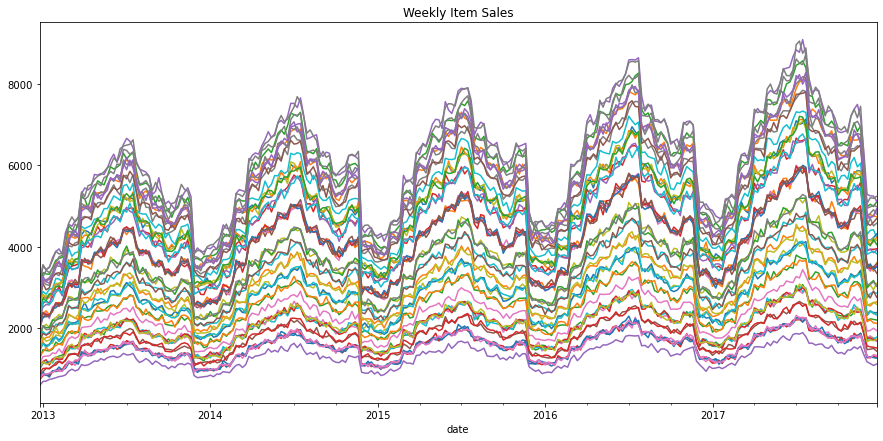

In [118]:
# The daily sales values seem very sporadic, we are now gonna plot the sum value of sales over a week
stores_sales_df1 = sales_train.copy()
stores = pd.DataFrame(stores_sales_df1.groupby(['date', 'item']).sum()['sales']).unstack()
stores = stores.resample('W',label='left').sum()
stores.sort_index(inplace = True)

display(stores.sample(10))

stores.plot(figsize=(15,7), title='Weekly Item Sales', legend=None)
plt.show()

sales                                                          \
store          1      2      3      4      5      6      7      8      9    
date                                                                        
2013-11-03  14389  20748  18323  16937  12076  12439  11114  19620  16886   
2015-10-25  16461  23469  20560  18945  13594  13826  12559  22263  19283   
2016-03-27  17686  25036  22057  20062  14680  14782  13537  23372  20371   
2013-02-24  11306  16266  14160  13371   9617   9688   8730  15507  13135   
2017-12-24  14015  19908  17822  16475  11823  11786  10870  19131  16292   
2015-08-16  18919  26604  23604  21577  15800  15769  14400  25305  21891   
2013-06-16  16596  23415  21012  19471  14031  14174  12647  22540  19316   
2014-03-09  14187  20305  18093  16576  12105  12226  11186  19471  16953   
2014-09-07  16780  23883  21125  19486  14068  13811  12793  22611  19481   
2016-03-20  16320  23041  20553  18747  13663  13684  12447  22134  18737   

                   
store          10  
date               
2013-11-03  18024  
2015-10-25  20491  
2016-03-27  21864  
2013-02-24  14036  
2017-12-24  17339  
2015-08-16  23383  
2013-06-16  20556  
2014-03-09  17632  
2014-09-07  21027  
2016-03-20  20125

sales                                                         \
store          1      2      3      4      5      6     7      8      9    
date                                                                       
2012-12-30   8449  11713  10345   9650   6836   7117  6238  11107   9421   
2013-01-06   9289  13451  11869  10886   7884   7917  7273  12787  10887   
2013-01-13   9287  13264  11660  10760   7851   7894  7120  12791  10753   
2013-01-20   9229  13329  11888  10747   7822   7932  7277  12606  10922   
2013-01-27   9826  14058  12429  11585   8267   8305  7471  13346  11422   
2013-02-03  10281  14771  13005  12205   8574   8705  7932  14284  12005   
2013-02-10  10337  14941  13127  12177   8816   8722  7987  14085  12172   
2013-02-17  10425  14783  12976  12171   8750   8653  7983  13912  12010   
2013-02-24  11306  16266  14160  13371   9617   9688  8730  15507  13135   
2013-03-03  12614  17674  15759  14193  10492  10541  9548  16892  14433   

                   
store          10  
date               
2012-12-30  10191  
2013-01-06  11659  
2013-01-13  11570  
2013-01-20  11546  
2013-01-27  12318  
2013-02-03  12804  
2013-02-10  12897  
2013-02-17  13103  
2013-02-24  14036  
2013-03-03  15559

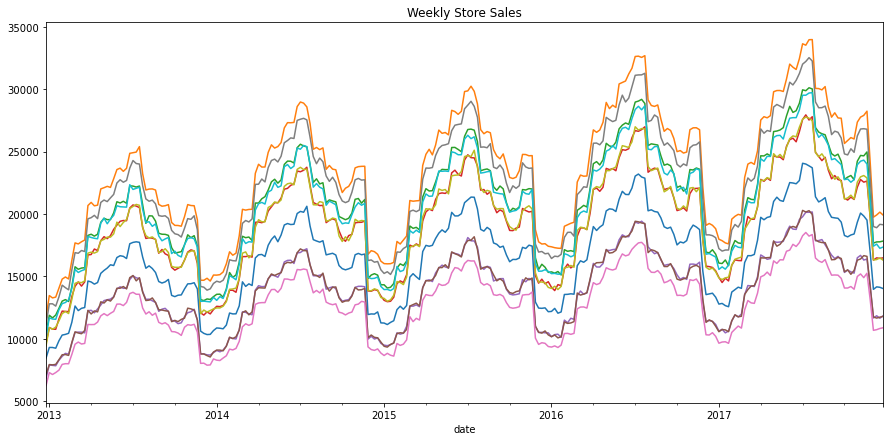

In [119]:
# The daily sales values seem very sporadic, we are now gonna plot the sum value of sales over a week
stores_sales_df = sales_train.copy()
stores = pd.DataFrame(stores_sales_df.groupby(['date', 'store']).sum()['sales']).unstack()
stores = stores.resample('W',label='left').sum()
stores.sort_index(inplace = True)

display(stores.sample(10))
display(stores.head(10))

stores.plot(figsize=(15,7), title='Weekly Store Sales', legend=None)
plt.show()

In [ ]:
# Need to visualise the trends, seasonality and other features (on both additive and multiplicative scales) here.

date_sales = sales_train.drop(['store','item'], axis=1).copy() 
y = date_sales['sales'].resample('MS').mean() 
y['2017':] #sneak peak
y.plot(figsize=(15, 7))

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()

# Still have to make sense of the plots and describe it, also, need to try and plot these components on a weekly basis, but on a smaller time scale as well (Say 3 months).

In [ ]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: 
#trend, seasonality, and noise.
# Here, we are using multiplicative models of decomposition, instead of additive ones
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot()

### Supporting Functions
These functions will be used to assist creation of data, to implement loss metrics that aren't implicit in scipy library, and a module to plot the results

In [147]:
# Will have to change this function to return a dataframe with index values as the date (in datetime index), and the sales values corresponding to the store and item_id, without 
# these columns in the returned data frame.
def create_data(df, store_id, item_id):
    '''
    This function creates a series containing the sales values of a particular item of a particular store (as prescribed in the argument values). This will return a pandas dataframe
    with datetime index.
    
    Args:
        df (dataframe) -> A multiindex dataframe containing store, item, and dates as index
        store_id (integer) -> The id of the store
        item_id (integer) -> The item number
    
    '''
    series = df.loc[(store_id,item_id,slice(None)),:]
    series_df1 = series.reset_index(['store', 'item'])
    new_series = series_df1.drop(['store', 'item'], axis = 1)
    new_series.index = pd.to_datetime(new_series.index)
    return new_series


def mean_absolute_percentage_error(y_true, y_pred, multioutput = 'raw_values'):
    '''
    This function returns the mean absolute percentage error of the values in form of a numpy array, if the multoutput is set to 'raw_values', and returns a single float value of 
    the average of loss, if the multioutput is set to 'uniform_average'
    
    Args:
        y_true (iterable) -> Representing the actual values of the output
        y_pred (iterable) -> Representing the predicted values of the output
        multioutput (string) -> Could either be 'raw_values', or 'uniform_average'
        
    Returns:
        A numpy array or a single float value depending on the multioutput argument.
    '''
    if multioutput == 'raw_values':
        return np.divide(np.abs(y_true - y_pred), np.abs(y_true)) * 100
    if multioutput == 'uniform_average':
        return np.mean(np.divide(np.abs(y_true - y_pred), np.abs(y_true)) * 100)

def total_error(actual_value, pred_value, metric):
    '''
    This function returns the total error of the predicted values when evaluated against the actual values. It returns a single float variable representing that error
    
    '''
    if metric<0 or metric>4:
        raise ValueError('The loss metric should be between 1 and 4, included')
    if metric == 0:
        error_term = mean_absolute_error(actual_value, pred_value, multioutput = 'uniform_average')
    if metric == 1:
        error_term = mean_squared_error(actual_value, pred_value, multioutput = 'uniform_average')
    if metric == 2: 
        error_term = mean_absolute_percentage_error(actual_value, pred_value, multioutput = 'uniform_average')
    if metric == 3:
        error_term = r2(actual_value, pred_value, multioutput = 'uniform_average')
    if metric == 4:
        error_term = smape(actual_value, pred_value, multioutput = 'uniform_average')
    return error_term
    



In [12]:
def smape(y_pred, y_true, multioutput = 'raw_values'):
    '''
    This function returns the symmetric mean absolute percentage error of the values in form of a numpy array, if the multoutput is set to 'raw_values', and returns a single float value of 
    the average of loss, if the multioutput is set to 'uniform_average'
    The formula for SMAPE has been defined here - https://www.forecastpro.com/Trends/forecasting101August2011.html
    
    Args:
        y_true (iterable) -> Representing the actual values of the output
        y_pred (iterable) -> Representing the predicted values of the output
        multioutput (string) -> Could either be 'raw_values', or 'uniform_average'
        
    Returns:
        A numpy array or a single float value depending on the multioutput argument.
        
    '''
    if multioutput == 'raw_values':
        return np.divide(np.abs(y_true - y_pred), np.abs((y_true + y_pred)/2) * 100)
    else:
        return np.mean(np.divide(np.abs(y_true - y_pred), np.abs((y_true + y_pred)/2)) * 100)
    

In [13]:
# A special point of note should be made here, if we have the data, for the actual points (even though we are making predictions for those time steps, and not using the actual data)
# we can very conveniently use this very function to make a reasonable plot. We will not have to worry about the broadcasting problem in arrays of different sizes, because, we will
# simply add the know actual values to the actual_value array for the prediction period as well. 
# Also, we need to define seperate plotting functions for each of the models becuase the predictions they make won't necessarily have actual values corresponding to them 
# and we will have to use particular plot methods for each of those methods (for eg, triple exponential smoothing can be predicted using brutlag method)

def plot_results(pred_value, actual_value, plot_intervals = False, scale = 2, plot_anomalies = False, metric = 4, pred_start = -1):
    '''
    This function plots the results of a time series prediction. It can also plot the intervals and anomalies, if so directed.
    
    Args:
        pred_value (iterable) -> Integer values of the predicted values of series
        actual_value (iterable) -> Integer values of the actual values of the series
        plot_intervals (boolean) -> Decides if the lower and upper bounds are to be plotted.
        plot_anomalies (boolean) -> Decides if the anomalies are to be plotted.
        scale (float) -> An hyperparameter for interval deduction.
        metric (integer) -> To decide the loss metric to be used
            0 - MAE
            1 - MSE
            2 - MAPE
            3 - R2
            4 - SMAPE
        pred_start (integer) -> A negative integer referring to the number of time steps that have been used as test data. 
        
    '''
    
    plt.figure(figsize = (15,7))
    plt.title('Prediction values for sales')
    plt.plot(pred_value, "g", label = "Predicted values")
    
    # Plot the confidence intervals of the smoothed values
    if plot_intervals:
        if metric<0 or metric>4:
            raise ValueError('The loss metric should be between 1 and 4, included')
        if metric == 0:
            error_term = mean_absolute_error(actual_value, pred_value, multioutput = 'raw_values')
        if metric == 1:
            error_term = mean_squared_error(actual_value, pred_value, multioutput = 'raw_values')
        if metric == 2: 
            error_term = mean_absolute_percentage_error(actual_value, pred_value, multioutput = 'raw_values')
        if metric == 3:
            error_term = r2(actual_value, pred_value, multioutput = 'raw_values')
        if metric == 4:
            error_term = smape(actual_value, pred_value, multioutput = 'raw_values')
        deviation = np.std(actual_value - pred_value)
        lower_bound = pred_value - (error_term + scale*deviation)
        upper_bound = pred_value + (error_term + scale*deviation)
        plt.plot(upper_bound, "r--", label = "Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index = actual_value.index, columns = actual_value.columns)
            anomalies[actual_value<lower_bound] = actual_value[actual_value<lower_bound]
            anomalies[actual_value>upper_bound] = actual_value[actual_value>upper_bound]
            plt.plot(anomalies, "ro", makersize = 1)
        
    plt.plot(actual_value, label = "Actual Values")
    plt.axvspan(len(actual_value) + pred_start, len(actual_value), alpha = 0.6, color = 'grey')
    plt.legend(loc = "upper left")
    # See if the total error term can be added to the plot (to compare the results of different models and different evaluation metrics)
    plt.grid(True)
    plt.show()
        
        

## Exponential Smoothing
The problem with exponential smoothing is that we can't use it to predict the trends of the data for very long periods (6 months in our case), and this limits the utility of this model, nonetheless, this can be used to make a naive prediction on a short term basis and serves as as a good estimate of a conservative prediction which can then be used to compare the volatility and credibility of the predictions made by our long term predictions. Think of it this way, if we were to make predictions for, lets say stock prices, and there is and a certain incident that causes the time series to behave unusually (like a chain of events set in motion due to some scandal or something), then we would want our model to quickly adopt itself to the new environment it has found itself in. Of course, there won't be enough data of such cataclysmic changes to make meaningful long term predictions, and in those scenarios, a manually tuned expectancy value derived from Exponential Smoothing will prove itself to be extremely useful.

#### Smoothing parameters
We will try and find the values of the smoothing parameters by passing the input values through a truncated conjugate gradient optmisation algorithm. This will help us ensure that we aren't just tuning those hyperparameters by ourselves, instead they are being set on a formal basis of how beneficial they are to the learning process.

The code for triple exponential smoothing will be completely different. To provide long term predictions along with deviations that are tuned on the basis of how far long the prediction horizon is. Also, the confidence intervals are derived using the brutlag method, and the parameter values are derived using the optimization function, rather than feeding them manually. I will create a seperate class for these predictions.

In [14]:
class Single_ES:
    
    """
    This model object will produce the Single Exponential smoothing values. Since it does not have the abilities to either smooth or to add trend, it can only be used to make a single 
    meaningful prediction. That is, just one time step can be predicted.
    Args:
        series (iterable) -> Actual time series
        alpha (float) -> Represents the parameter for single exponential smoothing
        scaling_factor (float) -> sets the width of the confidence interval
        
    Returns:
        result (iterable) -> A numpy array containing the results of smoothing
    
    """
    
    
    def __init__(self, series, alpha = 0.9, scaling_factor=2):
        self.series = series
        self.alpha = alpha
        # Scaling factor will only be used, if the plot is done here in this class
        self.scaling_factor = scaling_factor
        
          
    def single_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.result = [series[0]] # first value is same as series
        for t in range(1, len(series)):
            self.result.append(self.alpha * self.series[t] + (1 - self.alpha) * self.result[t-1])
        # Since we can't make more than one prediction, we can either print the plot here, or we can print the plot from the calling function where the 'model' object is created. 
        # There's no difference in the plots drawn from either.
        return np.array(self.result)

In [152]:
class Double_ES:
    
    """
    This class performs double exponential smoothing and updates the deviation, upper bound, and lower bound values for each time step. It also plots the results with its own function.
    There is no limit to the prediction horizon, however, since we are only relying on the trend update to make the predictions, it wouldn't be wise to set the n_preds value to be too 
    large.
    
    Args:
        series (iterable) -> Actual values array
        alpha, beta (float) -> Double exponential smoothing parameters
        n_preds (int) -> predictions horizon
        scaling_factor (float) - sets the width of the confidence interval and is used to determine the upper bound and lower bound
    
    """
    
    
    def __init__(self, series, alpha, beta, n_preds, scaling_factor=1):
        if type(series) is np.ndarray:
            series = pd.DataFrame(series)
        self.series = series
        self.alpha = alpha
        self.beta = beta
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(len(self.series)-1):
            sum += float(self.series.iloc[i+1] - self.series.iloc[i])
        return sum /(len(self.series))

          
    def double_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series.iloc[0]
                trend = self.initial_trend()
                self.result.append(self.series.iloc[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                
                self.PredictedDeviation.append(0)
                
                # Can't decide if I should add the error term (as I did in plot_results() function), into the evaluation of upper and lower bounds. I will have to rewrite that 
                # entire function here, and take metric as an argument as well. Will have to see the plot, to figure out if I should.
                self.UpperBound.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                
                # We could apply smoothing to the 'm*trend' part of the code in the next line, it will ensure that the function isn't running just on final trend value, but is 
                # also considering the trend values of the earlier time steps. Will have to see the results to alter this part.
                self.result.append(smooth + m*trend)
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series.iloc[i]
                last_smooth, smooth = smooth, self.alpha*(val) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                self.result.append(smooth+trend)
                
                # Instead of calculating the standard deviation of the results, we will here calculate the deviation using a variant of brutlag method, with the only difference being,
                # instead of using gamma as the parameter for deviation updata, we will use a fixed value of 0.5 (which we can adjust according to the results)
                self.PredictedDeviation.append(0.5 * np.abs(self.series.iloc[i] - self.result[i]) 
                                               + (1- 0.5)*self.PredictedDeviation[-1])
            
            # Again, the error term can be added here (to grant the model more versatility)
            self.UpperBound.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBound.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)

        
    def plot_Double_ES(self, test_data, plot_intervals = True, plot_anomalies = True, aggregated = True):
        '''
        Function plots the results for DES. It can plot the results, lower bound, and upper bound even for time steps that do not have actual values given.
        This plot function is more geared towards the actual industry situations where we are deploying the model for predictions without having the 'actual observed values' given.
        
        args:
            test_data (dataframe) -> Dataframe representing the last 180 values indexed according to their date time index values
            plot_intervals (boolean) -> Defines if we want to plot the confidence intervals
            plot_anomalies (boolean) -> Defines if we want to plot the anomalies
            aggregated (boolean) -> Determines whether or not we want to resample our plots on a weekly basis
        
        '''
        self.result = pd.DataFrame(np.array(self.result))
        any_df = pd.concat([self.series, test_data], axis = 0)
        self.result.index = pd.to_datetime(any_df.index)
        t = self.series.index
        l = len(self.series)
        self.series = pd.concat([self.series, test_data], axis = 0)
        
        if plot_intervals:
            self.UpperBound = pd.DataFrame(self.UpperBound)
            self.UpperBound.index = self.result.index
            self.LowerBound = pd.DataFrame(self.LowerBound)
            self.LowerBound.index = self.result.index
            
        if plot_anomalies:
            self.anomalies = np.array([np.NaN]*l)
            self.anomalies = pd.DataFrame(self.anomalies)
            self.anomalies.index = t
            drop_list = []
            
            for i in range(len(self.anomalies)):
                if self.series.values[i][0] < self.LowerBound.values[i][0]:
                    self.anomalies.iloc[i] = self.series.values[i][0]
                if self.series.values[i][0] > self.UpperBound.values[i][0]:
                    self.anomalies.iloc[i] = self.series.values[i][0]
                else:
                    drop_list.append(i)
            
            self.anomalies.drop(self.anomalies.index[drop_list], axis = 0, inplace = True)
        
        # This part prints the results in an aggregated form and everything is resampled according to weekly basis
        if aggregated == True:
            results_aggregated = self.result.resample('W', label = 'left').sum()
            actual_aggregated = self.series.resample('W', label = 'left').sum()
            UpperBound_aggregated = self.UpperBound.resample('W', label = 'left').sum()
            LowerBound_aggregated = self.LowerBound.resample('W', label = 'left').sum()
            
            # The following code is to find aggregated anomalies. 
            l1 = len(results_aggregated)
            anomalies_aggregated = np.array([np.NaN]*l1)
            anomalies_aggregated = pd.DataFrame(anomalies_aggregated)
            anomalies_aggregated.index = results_aggregated.index
            drop_list1 = []
            for j in range(len(anomalies_aggregated)):
                if actual_aggregated.values[j][0] < LowerBound_aggregated.values[j][0]:
                    anomalies_aggregated.iloc[j] = actual_aggregated.values[j][0]
                if actual_aggregated.values[j][0] > UpperBound_aggregated.values[j][0]:
                    anomalies_aggregated.iloc[j] = actual_aggregated.values[j][0]
                else:
                    drop_list1.append(j)
            anomalies_aggregated.drop(anomalies_aggregated.index[drop_list1], axis = 0, inplace = True)

            plt.figure(figsize = (15,7))
            plt.plot(results_aggregated, "g", label ="Predicted Values")
            plt.plot(actual_aggregated, "b", label = "Actual Values")
            plt.plot(UpperBound_aggregated, "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
            plt.plot(LowerBound_aggregated, "r--")
            plt.fill_between(x = results_aggregated.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
            plt.axvspan(test_data.index[0], test_data.index[-1], alpha = 0.4, color = "grey")
            plt.plot(anomalies_aggregated, "o", color = "r", markersize = 5, label = "Anomalies")
            plt.grid(True)
            plt.legend(loc = "upper left")
            plt.show()
        
        # The following part prints the results without aggregation
        else:
            plt.figure(figsize = (15,7))
            plt.plot(self.result, "g", label = "Predicted Values")
            plt.title("Prediction values for sales using Triple Exponential Smoothing")
            plt.plot(self.series, "b", label = "Actual Values")
            plt.plot(self.UpperBound, "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
            plt.plot(self.LowerBound, "r--", alpha = 0.3)
            plt.fill_between(x = self.result.index, y1 = self.UpperBound.values.ravel(), y2 = self.LowerBound.values.ravel(), alpha = 0.2, color = "grey")
            plt.axvspan(test_data.index[0], test_data.index[-1], alpha = 0.6, color = 'grey')
            plt.plot(self.anomalies, "o", color = "r", markersize = 5, label = "Anomalies")
            plt.show()       
        

In [143]:
class Triple_ES:
    
    """
    In Triple Exponential Smoothing, we implement the Holt-Winters model, and derive the outliers using the brutlag method
    
    Args:
        series (iterbale) -> Actual values array
        slen (int) -> Length of a season
        alpha, beta, gamma (float) -> Holt-Winters model coefficients
        n_preds (int) -> predictions horizon
        scaling_factor (float) -> sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, alpha, beta, gamma, n_preds = 180, scaling_factor=1.5, slen = 365):
        if type(series) is np.ndarray:
            series = pd.DataFrame(series)
        self.series = series
        self.slen = int(slen)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series.iloc[i+self.slen] - self.series.iloc[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append((self.series.iloc[self.slen*j:self.slen*j+self.slen].sum()[0])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series.iloc[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBound = []
        self.LowerBound = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series.iloc[0]
                trend = self.initial_trend()
                self.result.append(self.series.iloc[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBound.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBound.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series.iloc[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series.iloc[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBound.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBound.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

    
    
    def plot_Triple_ES(self, test_data, plot_intervals = True, plot_anomalies = True, aggregated = True):
        '''
        Function plots the results for TES. It can plot the results, lower bound, and upper bound even for time steps that do not have actual values given.
        This plot function is more geared towards the actual industry situations where we are deploying the model for predictions without having the 'actual observed values' given.
        
        args:
            test_data (dataframe) -> Datetime index wise representation of the last 180 day values.
            plot_intervals (boolean) -> Defines if we want to plot the confidence intervals
            plot_anomalies (boolean) -> Defines if we want to plot the anomalies
            aggregated (boolena) -> Decides whether or not we want to resample our output on a weekly basis
        
        '''
        self.result = pd.DataFrame(self.result)
        any_df = pd.concat([self.series, test_data], join = "inner", axis = 0)
        self.result.index = pd.to_datetime(any_df.index)
        t = self.series.index
        l = len(self.series)
        self.series = pd.concat([self.series, test_data], axis = 0)
        #display(self.series.tail(20))
        #display(test_data.tail(20))
        #display(self.result)
        
        if plot_intervals:
            self.UpperBound = pd.DataFrame(self.UpperBound)
            self.UpperBound.index = self.result.index
            self.LowerBound = pd.DataFrame(self.LowerBound)
            self.LowerBound.index = self.result.index

        if plot_anomalies:
            self.anomalies = np.array([np.NaN]*(l))
            self.anomalies = pd.DataFrame(self.anomalies)
            self.anomalies.index = t
            drop_list = []
            
            for i in range(len(self.anomalies)):
                if self.series.values[i][0] < self.LowerBound.values[i][0]:
                    self.anomalies.iloc[i] = self.series.values[i][0]
                if self.series.values[i][0] > self.UpperBound.values[i][0]:
                    self.anomalies.iloc[i] = self.series.values[i][0]
                else:
                    drop_list.append(i)
            
            self.anomalies.drop(self.anomalies.index[drop_list], axis = 0, inplace = True)
            
        # This part prints the results in an aggregated form and everything is resampled according to weekly basis
        if aggregated == True:
            results_aggregated = self.result.resample('W', label = 'left').sum()
            actual_aggregated = self.series.resample('W', label = 'left').sum()
            UpperBound_aggregated = self.UpperBound.resample('W', label = 'left').sum()
            LowerBound_aggregated = self.LowerBound.resample('W', label = 'left').sum()
            
            # The following code is to find aggregated anomalies. 
            l1 = len(results_aggregated)
            anomalies_aggregated = np.array([np.NaN]*l1)
            anomalies_aggregated = pd.DataFrame(anomalies_aggregated)
            anomalies_aggregated.index = results_aggregated.index
            drop_list1 = []
            for j in range(len(anomalies_aggregated)):
                if actual_aggregated.values[j][0] < LowerBound_aggregated.values[j][0]:
                    anomalies_aggregated.iloc[j] = actual_aggregated.values[j][0]
                if actual_aggregated.values[j][0] > UpperBound_aggregated.values[j][0]:
                    anomalies_aggregated.iloc[j] = actual_aggregated.values[j][0]
                else:
                    drop_list1.append(j)
            anomalies_aggregated.drop(anomalies_aggregated.index[drop_list1], axis = 0, inplace = True)
            

            plt.figure(figsize = (15,7))
            plt.plot(results_aggregated, "g", label ="Predicted Values")
            plt.plot(actual_aggregated, "b", label = "Actual Values")
            plt.plot(UpperBound_aggregated, "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
            plt.plot(LowerBound_aggregated, "r--")
            plt.fill_between(x = results_aggregated.index, y1 = UpperBound_aggregated.values.ravel(), y2 = LowerBound_aggregated.values.ravel(), alpha = 0.2, color = "grey")
            plt.axvspan(test_data.index[0], test_data.index[-1], alpha = 0.4, color = "grey")
            plt.plot(anomalies_aggregated, "o", color = "r", markersize = 5, label = "Anomalies")
            plt.grid(True)
            plt.legend(loc = "upper left")
            plt.show()
        
        # The following part prints the results without aggregation
        else:
            plt.figure(figsize = (15,7))
            plt.plot(self.result, "g", label = "Predicted Values")
            plt.title("Prediction values for sales using Triple Exponential Smoothing")
            plt.plot(self.series, "b", label = "Actual Values")
            plt.plot(self.UpperBound, "r--", alpha = 0.3, label = "Upper Bound/ Lower Bound")
            plt.plot(self.LowerBound, "r--", alpha = 0.3)
            plt.fill_between(x = self.result.index, y1 = self.UpperBound.values.ravel(), y2 = self.LowerBound.values.ravel(), alpha = 0.2, color = "grey")
            plt.axvspan(test_data.index[0], test_data.index[-1], alpha = 0.6, color = 'grey')
            plt.plot(self.anomalies, "o", color = "r", markersize = 5, label = "Anomalies")
            plt.show()

In [155]:
# This cell is to include the data preparation part, where we do the train test split on a rolling basis. This function will be called by the proceeding optimization function.

def desCVscore(params, series, loss_function=mean_squared_error):
    """
        Returns error on CV  and thereby helps decide the best parameters for Double Exponential Smoothing
        
        Args:
        
            params -> vector of parameters for optimization
            series -> dataset with timeseries
        
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=9) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = Double_ES(series=values[train], alpha=alpha, beta=beta, n_preds=len(test))
        model.double_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [156]:
def tesCVscore(params, series, loss_function=mean_squared_error, slen=365):
    """
        Returns error on CV  and thereby helps decide the best parameters for Triple Exponential Smoothing
        
        Args:
            params -> vector of parameters for optimization
            series -> dataset with timeseries
            slen -> season length for Triple Exponential Smoothing model. Here the season length is obviously 365.
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=9) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = Triple_ES(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [153]:
def des_forecast(train_data, test_data):
    '''
    
    
    
    '''
    #Initializing model parameters, alpha and beta
    x_des = [0,0]

    # Minimizing the loss function. Still have to figure out a way to use MAPE loss function in this metric as well
    #opt_des = minimize(desCVscore, x0 = x_des, args = (train_data, mean_squared_error), method = "TNC", bounds = ((0,1), (0,1)))

    # Finding optimal parameter values
    #alpha, beta = opt_des.x
    alpha = 0.90
    beta = 0.001
    print("Alpha value is: ", alpha)
    print("Beta value is:", beta)

    # Now we train the model with these values of alpha and beta
    model_des = Double_ES(train_data, alpha, beta, n_preds = 180, scaling_factor = 1)
    model_des.double_exponential_smoothing()
    model_des.plot_Double_ES(test_data, plot_intervals = True, plot_anomalies = True)
    anomalies_des = model_des.anomalies
    result_des = model_des.result
    error_des = total_error(test_data.values.ravel(), result_des[-180:].values.ravel(), 1)
    print("The total error using mean squared error is", error_des)
    display(anomalies_des)
    return result_des, anomalies_des

In [150]:
def tes_forecast(train_data, test_data):
    '''
    
    
    
    
    '''
    # Initializing model parameters, alpha and beta and gamma
    x_tes = [0,0,0]

    # Minimizing the loss function. Still have to figure out a way to use SMAPE loss function in this metric as well
    #opt_tes = minimize(tesCVscore, x0 = x_tes, args = (train_data, mean_squared_error), method = "TNC", bounds = ((0,1), (0,1),(0,1)))

    # Finding optimal parameter values
    #apha, beta, gamma = opt_tes.x
    alpha = 0.9
    beta = 0.0001
    gamma = 0.9
    print("Alpha value is: ", alpha)
    print("Beta value is:", beta)
    print("Gamma Value is : ", gamma)

    # Now we train the model with these values of alpha, beta and gamma
    
    model_tes = Triple_ES(train_data, alpha, beta, gamma, slen = 365, n_preds = 180, scaling_factor = 0.9)
    model_tes.triple_exponential_smoothing()
    model_tes.plot_Triple_ES(test_data, plot_intervals = True, plot_anomalies = True)
    anomalies_tes = model_tes.anomalies
    result_tes = model_tes.result
    error_tes = total_error(test_data.values.ravel(), result_tes[-180:].values.ravel(), 1)
    #UpperBound_tes = model_tes.UpperBound
    #LowerBound_tes = model_tes.LowerBound
    display(anomalies_tes)
    print("The total error using mean squared error is", error_tes)
    #display(result_tes[-180:])
    #display(test_data)
    #total_data = pd.concat([train_data, test_data], axis = 0)
    
    return result_tes, anomalies_tes


### Actual Implementation of Exponential Smoothing

Alpha value is:  0.9
Beta value is: 0.001


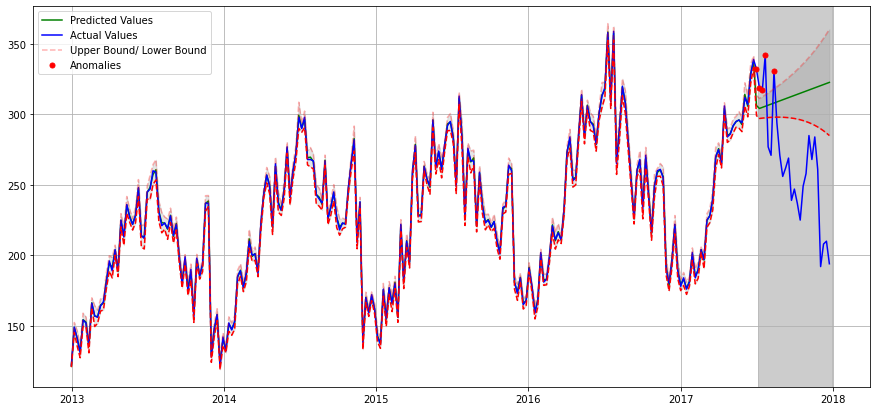

The total error using mean squared error is 137.129052890367


,0
date,
2013-01-02,19.0
2013-01-04,21.0
2013-01-05,23.0
2013-01-09,28.0
2013-01-12,24.0
...,...
2017-06-17,61.0
2017-06-21,47.0
2017-06-23,53.0


Alpha value is:  0.9
Beta value is: 0.0001
Gamma Value is :  0.9


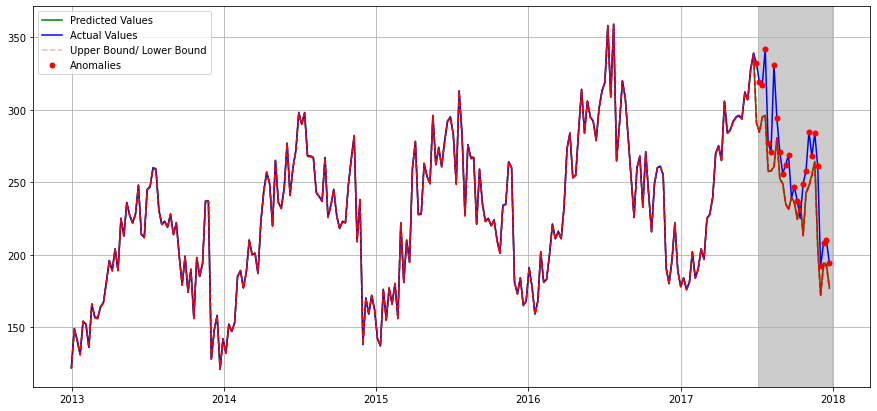

,0
date,
2013-01-02,19.0
2013-01-05,23.0
2013-01-06,24.0
2013-01-09,28.0
2013-01-12,24.0
...,...
2017-06-21,47.0
2017-06-23,53.0
2017-06-29,43.0


The total error using mean squared error is 86.13996624336131


In [154]:
# This cell will include the main wrapper part of the code, which will first call the data creation function followed by a call to the optimization function to derive the parameter values, and then will create objects for each of the
# three types of ES models, and produce the results, then use those objects to call the plot function of TES and DES. Here, I will also write 
# the code for identifying the anomalies by calling the necessary functions. 

store_chain_train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
storewise_train = store_chain_train.set_index(['store', 'item', 'date'])

#The following part can be put into a loop for all stores and all items. I won't be doing it for now
store_id = 10     #Random store id
item_id = 40      # Random item id
series_data = create_data(storewise_train, store_id, item_id)
train_data = series_data.iloc[:-180]
test_data = series_data.iloc[-180:]
#display(train_data)
#display(test_data)


# The following code is for Double Exponential Smoothing. The function defintion des_forecast is to house the following code
results_des, anomalies_des = des_forecast(train_data, test_data)
#plot_results(results_des, series_data, plot_intervals = True, scale = 2, plot_anomalies = True, metric = 4, pred_start = -180)


# The following code is for Triple Exponential Smoothing.
results_tes, anomalies_tes = tes_forecast(train_data, test_data)
#plot_results(results_tes, series_data, plot_intervals = False, scale = 2, plot_anomalies = False, metric = 4, pred_start = -180)





In [112]:
store_chain_train_df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
datewise_train = store_chain_train_df.set_index('date')
display(datewise_train)
any_array = np.random.rand(len(store_chain_train_df)) * 100
display(any_array)
any_array = pd.DataFrame(any_array)
any_df2 = np.random.rand(len(store_chain_train_df)) * 150
any_df2 = pd.DataFrame(any_df2)
any_array.index = datewise_train.index
any_array.index = pd.to_datetime(any_array.index)
display(any_array)
any_df2.index = any_array.index
print(any_df2.index)
print(any_df2.index[0])
print(any_df2.index[-1])

'''plt.figure(figsize = (15,7))
plt.plot(any_df2.iloc[:1900], color = "g")
plt.plot(any_array.iloc[-900:], color = "b")
plt.grid(True)
plt.show()
'''



,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


array([92.19864302, 78.03276076, 27.98110988, ..., 79.28384157,
        0.17594428, 36.47972816])

,0
date,
2013-01-01,92.198643
2013-01-02,78.032761
2013-01-03,27.981110
2013-01-04,60.779242
2013-01-05,92.138082
...,...
2017-12-27,22.049553
2017-12-28,37.608739
2017-12-29,79.283842


DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=913000, freq=None)
2013-01-01 00:00:00
2017-12-31 00:00:00


'plt.figure(figsize = (15,7))\nplt.plot(any_df2.iloc[:1900], color = "g")\nplt.plot(any_array.iloc[-900:], color = "b")\nplt.grid(True)\nplt.show()\n'

## SARIMA Part